# Depth Estimator Example

The following tutorial is meant as a quick intro to Kalman Filtering. We will assume you know the general theory. Now, let's put this knowledge into action and produce some actual code!

We will consider the case of estimating an underwater robot's depth. For this purpose, the robot is equipped with a pressure sensor, providing us with (noisy) 
pressure data.

The following figure depicts our robot in a body of water. Following the ROS coordinate frame conventions, we will define a map frame with $z$-axis pointing upwards. Furthermore, the origin lies on the water surface. Therefore, we expect negative $z$-values when the robot is submerged. The dashed line shows the pressure sensor's vertical position.

<center><img src="figs/depth_estimator_example.png" width="400">




## Choice of system states

First, we think about what states we might want or need to estimate. While the fluid pressure gives us information about the robot's depth, without any further sensors, we cannot infer the x- and y-position. Therefore, the obvious choice would be to just include the $z$-coordinate, resulting in

$$x=\begin{bmatrix}z\end{bmatrix}.$$

However, it might make sense to include the velocity in $z$-direction as well. We'll come to this in a bit. For now, let's directly start with

$$\bm{x}=\begin{bmatrix}x_1\\x_2\end{bmatrix}=\begin{bmatrix}z\\v_z\end{bmatrix}.$$

Regarding notation, since in state estimation, the measurement is usually denoted by $\bm{z}$, we will stick to $\bm{x}=\begin{bmatrix}x_1\\x_2\end{bmatrix}$.

## Prediction step and choice of process function

The process function is used for propagating the estimated state into the future. This comes in handy when we receive measurements with a low frequency, one that is too low for feedback control. 
However, note that the Kalman filter is not able to magically foresee the future. Note, we may make "educated" predictions using the process function. In any case, we will still need to gather measurements to gain information on our state!

This process function can be based e. g. on a physical model. However, in real life we seldom have accurate models of our physical systems. Therefore, we recommend to start simple.

**We will see that you do not actually need the "correct" physical model.**


### The most simple approach

What is the most simple process model you can think of?  
Right, in between time steps, let's assume nothing changes at all, i.e. new state = old state, resulting in 

$$\bm{x}(k+1) = f(\bm{x}(k)) = \bm{x}(k). $$

For our 2-dimensional state, we can express this as

$$f(\bm{x}) = \bm{A} \cdot \bm{x},$$
with $\bm{A}=\begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}$.

Give this a try and you will see that in a lot of cases, this is already sufficient.

### Using a constant velocity model

As a first upgrade, we recommend using a simple constant velocity model. This comes with two advantages. First, the prediction quality improves, and, second, you get an estimate of the velocity which can be used in a subsequent controller.
Here, we use our velocity estimate at hand to propagate our depth estimate. Assuming constant velocity in between time steps, we get

$$\bm{x}(k+1) = f(\bm{x}) = \begin{bmatrix}x_1(k) + \text{d}t \cdot x_2(k) \\ x_2(k)\end{bmatrix}.$$

Taking the Jacobian of this function results in

$$\bm{A}= \begin{bmatrix}1 & dt\\0 & 1\end{bmatrix}.$$

We will see in the coding example that by using this process model, we get the velocity estimates "for free", without actually measuring any velocity data! Maybe the Kalman filter is magic, after all?


## Update step and choice of measurement function

Next, we need to model the measurement. Let's think about the physical relationship between pressure and depth

$$p=\rho g h + p_0,$$

where $\rho$ is the fluid's density, $g$ is the gravitional acceleration, $h$ is the height of the fluid column, and $p_0$ is the atmospheric pressure.

However, for our Kalman filter, we need a measurement function $h(\bm{x})$ describing the expected measurement given our state.
Given a certain depth $x_1$, what is the pressure we expect to measure?
Solving the equation above for the height of the fluid column results in
$$\bm{z} = h(\bm{x})= p_0 + \rho g (-x_1) $$

Taking the Jacobian, we get

$$\bm{H}= \begin{bmatrix}-\rho g & 0\end{bmatrix}$$

In the following, we will approximate $\rho g$ with $10^4$.


# Kalman filter equations

We have thought about our process and measurement model. Now, let's have a look at the Kalman filter equations. Although in this case our system is linear, we will directly look at the Extended Kalman filter, short EKF. Applying the Extended Kalman filter to a linear system results in a linear Kalman filter!

There are many different notations out there, for convenience, let's stick to Wikipedia in this tutorial. Wikipedia's always correct, right? The equations can be found here: https://en.wikipedia.org/wiki/Extended_Kalman_filter#Discrete-time_predict_and_update_equations 


<center><img src="figs/ekf_equations_wikipedia.png" width="800"></center>

We note a few differences: What we called the $\bm{A}$-matrix so far is called $\bm{F}$ here, so let's stick to that.
Additionally, the process model here includes the control input $\bm{u}$. For simplicity reasons, we highly recommend not including the control input in the prediction. Otherwise, we would require a model which captures the relation from our control input $u$ -- in our example a value -1..1 -- to our state $\bm{x}$. Feel free to derive it at a later stage (e.g. the final project - it is quite some work to get a suitable model), but for the moment let's assume its unavailable.

### Notation

The notation is explained in the Wikipedia article on the [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter#Underlying_dynamic_system_model).



# Implementation

It's time to put these equations into code!
We're starting with a few general definitions:

In [1]:
import numpy as np

np.random.seed(1)  # for repeatability, so we use seed 1 again if we run the algorithm again.

atmospheric_pressure = 101300  # in Pa
dim_state = 2
dim_measurement = 1

t_end = 20  # in s
dt = 0.1  # in s, thus, updating at 10 hz
t = np.arange(start=0, stop=t_end, step=dt)  # time vector for our time simulation

## Values to play around with

In the following, we define parameters used for our Kalman filter. **Change these parameters to see the effect on our estimation performance!**

### Initial state and variance 
We need to initialize our estimate which is defined by its mean and its covariance matrix. A common choice is zero for all states. How sure are we about our initial guess? That is what we set with $\bm{P}_0$.

A comment to the Gussian experts among you: If you went carefully through our equations while not forgetting about our underlying physical setup (depth estimation for a underwater robot), you may have noticed a simplification as we chose the initial state to be zero while we assume a Gaussian, thus symmetric, distribution around this mean value. Feel free to spend a thought what this means on the physical level (first 3 DMs in Slack will get a X-mas surprise). 
Anyhow, we follow our gut's feeling here and head on with this simplification.

In [2]:
x0_est = np.array([[0], [0]])  # initial guess for our states

depth_initial_std_dev = 0.5  # in m, default: 0.5
depth_velocity_initial_std_dev = 0.5   # in m/s, default: 0.5

P0 = np.array([[depth_initial_std_dev ** 2, 0], [0, depth_velocity_initial_std_dev ** 2]])  # covariance of initial guess

### Process noise
How much is uncertainty increasing each process step? In reality, this is a tuning parameter and as a little spoiler some people say 'filter tuning is more an art than a science', but we want to learn about the effects of the individual parameters in our tutorial, right?

In general, increasing this process noise covariance matrix leads to higher uncertainty increase during the prediction step. Consequently, it leads to a quicker correction when receiving measurements.

It might make sense to have this covariance $Q$ depend on the time span $\text{d}t$ between prediction steps... (the longer the prediction time step, the more...)


In [3]:
depth_std_dev = 0.0005  # in m, default: 0.0005
depth_velocity_std_dev = 0.05  # in m/s, default: 0.05
Q = np.diag([depth_std_dev ** 2, depth_velocity_std_dev ** 2])

### Measurement noise
How much do we trust the measurements? This is also a tuning parameter. 

Increasing the measurement noise's covariance leads to mistrusting the received measurements more. This means the estimated states will 'follow' new measurements less quickly - leading to a smoother curve but also more lag.

In [4]:
pressure_std_dev = 100  # in Pa, default: 100
R = np.array([pressure_std_dev ** 2]).reshape((-1, 1))

### Probability that a measurement is lost
We will add this to show what happens when long times between measurement updates pass. 

In [5]:
drop_measurement_probability = 0.5  # default: 0.5

### *Real* system dynamics and measurement noise

We need to simulate the system that we want to observe. Normally, this would be done by our simulation environment, i.e. Gazebo, or the real world.

As an example, we will have a sinusoidal movement around the *true* initial depth position. Note, this is not necessarily our estimated mean $x_0$.
We will assume perfect dynamics. However, we will make the measurements noisy. Give it a try and vary the amounts of noise and see its influence on the results. 

The Kalman Filter is the optimal state estimator for linear systems with *Gaussian* noise - it would be interesting to try out the effect of other noise distributions!


In [6]:
## These lines of code would be done by Gazebo or the real world in ROS!

# initialize values
scaling = 0.2
x0_true = np.array([[-0.5], [scaling]])

# true measurement noise used for computation of received measurements
pressure_std_dev_true = 100  # Pascal, default: 100

def true_system_dynamics(t):
    # oscillating around initial depth
    return np.array([[scaling * np.sin(t) + x0_true[0, 0]], [scaling * np.cos(t)]])

def true_meas_function(x):
    # add zero-mean noise, doesn't have to be Gaussian - would be fun to try out other distributions!
    noise = np.random.normal(0, pressure_std_dev_true)
    return -x[0, 0] * 1.0e4 + atmospheric_pressure + noise

## Function definitions
The heart of our Kalman Filter. These lines implement the Kalman filter equations from above.

In [7]:
def h_fun(depth):
    return -depth * 1.0e4 + atmospheric_pressure

def get_h_jacobian():
    return np.array([-1.0e4, 0.0]).reshape((1, -1))

def f_fun(dt, x_est):
    return np.array([x_est[0,0] + dt * x_est[1,0], x_est[1,0]]).reshape((-1,1))

def get_f_jacobian(dt):
    return np.array([[1, dt], [0, 1]])
    
def predict(dt, x_est, P):
    """ invoke this function at each time step to propagate the state """
    x_est_new = f_fun(dt, x_est)
    f_jacobian = get_f_jacobian(dt)
    P_new = f_jacobian @ P @ f_jacobian.transpose() + Q
    return x_est_new, P_new

def update(z, x_est, P):
    """ invoke this function each time a new measurement is received """
    h_jacobian = get_h_jacobian()
    
    # estimated pressure measurement
    z_est = h_fun(x_est[0, 0])
    
    # innovation
    y = np.asarray(z - z_est).reshape((-1,1))
    
    # compute Kalman gain
    S = h_jacobian @ P @ h_jacobian.transpose() + R   # innovation covariance
    K = P @ h_jacobian.transpose() @ np.linalg.inv(S)
    
    # update state
    x_est_new = x_est + K @ y
    
    # update covariance
    P_new = (np.eye(dim_state) - (K @ h_jacobian)) @ P
    return x_est_new, P_new

## Book-keeping for plotting
Saving our estimates in order to make nice plots later!   
**You can ignore this block, it's purely for data storage. It does not have anything to do with our state estimation implementation.** 

In [8]:
x_true_all = np.zeros([dim_state, t.size])
x_est_all = np.zeros([dim_state, t.size])
P_all = np.zeros([dim_state, t.size])  # we'll only store the diagonal
meas_received_all = np.zeros([dim_measurement, t.size])

# store initial values
x_true_all[:, 0] = x0_true[:, 0]
x_est_all[:, 0] = x0_est[:, 0]
P_all[:, 0] = np.diag(P0)
meas_received_all[:, 0] = np.NaN

## Let's actually simulate!

In [9]:
x_est = x0_est
P = P0
t_last = 0

for idx, t_now in enumerate(t[1:,]):
    
    ## True system dynamics - this step is normally done by simulation environment/real world
    x_true = true_system_dynamics(t_now)
        
    ## Process step - propagating estimated state
    dt_ =  t_now - t_last  # compute actual time difference since last prediction
    t_last = t_now
    x_est_next, P_next = predict(dt_, x_est, P)
    
    # Do we get a measurement?
    if (np.random.uniform() > drop_measurement_probability):
        # Generating (noisy) measurement - also normally done by simulation environment/real sensor
        z_true = true_meas_function(x_true)
        
        ## Measurement update - finally fuse some measurements :-)
        x_est_next, P_next = update(z_true, x_est_next, P_next)

        # we will save the directly computed depth from this measurement received
        meas_received_all[:, idx+1] = - (z_true - atmospheric_pressure) / 1.0e4
    else:
        # no measurement received :-(
        meas_received_all[:, idx+1] = np.NaN
    
    # save variables for plotting
    x_true_all[:, idx+1] = x_true.reshape(-1)
    x_est_all[:, idx+1] = x_est_next.reshape(-1)
    P_all[:, idx+1] = np.diag(P_next)
    
    x_est, P = x_est_next, P_next

## A look at the results

We will produce some nice plots in the following.

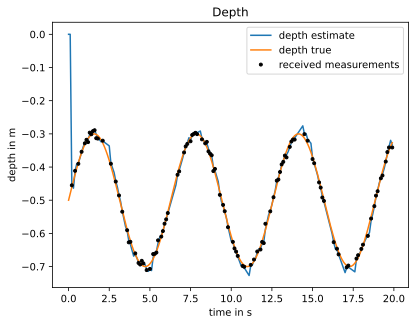

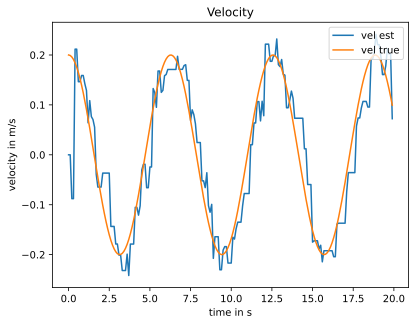

In [10]:
import matplotlib.pyplot as plt

# render plots as vector graphics to avoid ugly, blury plots
%config InlineBackend.figure_formats = ['svg']

plt.figure()
plt.title('Depth')
plt.xlabel('time in s')
plt.ylabel('depth in m')
plt.plot(t, x_est_all[0, :], label='depth estimate')
plt.plot(t, x_true_all[0, :], label='depth true')
plt.plot(t, meas_received_all[0, :], '.k', label='received measurements')
plt.legend(loc='upper right')

plt.figure()
plt.title('Velocity')
plt.xlabel('time in s')
plt.ylabel('velocity in m/s')
plt.plot(t, x_est_all[1, :], label='vel est')
plt.plot(t, x_true_all[1, :], label='vel true')
plt.legend(loc='upper right')

plt.show()

You can nicely see the assumption of constant velocity in between time steps. The estimated velocity can only be updated each time we receive a new pressure measurement.

The 'received measurements' plotted in black are the directly computed depths resulting from the received (noisy) pressure measurements.

## Comparison with Moving Average Filter

You might ask yourself now, how is the Kalman filter comparing to a simple moving average filter? What's the benefit of all this work?

We can compute the moving average in post-processing as follows:

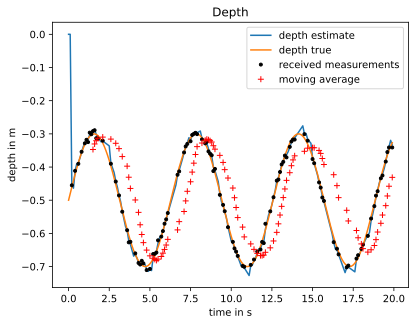

In [11]:
import pandas as pd

# window size for moving average filter - how many past data points are considered?
window = 10

plt.figure()
plt.title('Depth')
plt.xlabel('time in s')
plt.ylabel('depth in m')
plt.plot(t, x_est_all[0, :], label='depth estimate')
plt.plot(t, x_true_all[0, :], label='depth true')
plt.plot(t, meas_received_all[0, :], '.k', label='received measurements')

# for comparison: moving average filter in post-processing
t_only_meas_data = t[~np.isnan(meas_received_all[0, :])]
meas_all_without_nan = meas_received_all[0, :][~np.isnan(meas_received_all[0, :])]
moving_average = pd.Series(meas_all_without_nan).rolling(window=window).mean()
plt.plot(t_only_meas_data, moving_average, '+r', label='moving average')

plt.legend(loc='upper right')

plt.show()

The effect of the moving average filter depends on its window size. For larger windows, we consider more data points in the past. This smoothes out the curve, but also increases the lag. Smaller windows decrease lag, but also result in less smooth data.

We can see that we only get as many data points as we receive actual measurements. Whereas, with the Kalman filter, even when we don't receive measurments for a while, the state still gets propagated using our constant velocity process model. And this prediction is not far off for most parts of the sinusoidal movement!

For feedback control, having a guaranteed high-frequency state estimate is crucial. This is one of the main benefits of using the Kalman filter.

## Looking at variance
We are not only estimating the system's states. The Kalman filter also provides us with an estimate of these states' uncertainty. Let's have a look!

In the following, we are additionally plotting the estimated states plus and minus their standard deviation. The standard deviation for e.g. the depth at time step $k$ is the square root of the first diagonal entry of $\bm{P}(k)$.

/tmp/ipykernel_16727/1338910458.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_start = int(np.argwhere(t>13.5)[0])
/tmp/ipykernel_16727/1338910458.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_stop = int(np.argwhere(t>17.5)[0])


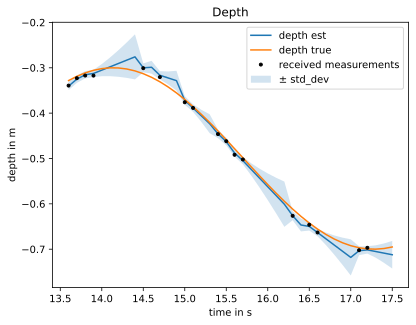

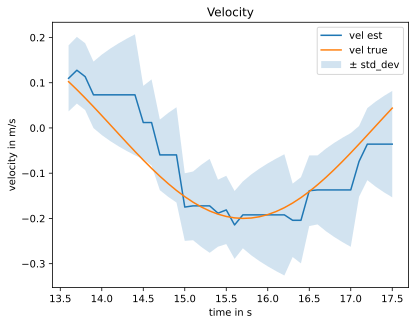

In [12]:
# we will crop the plotted time for better visibility
idx_start = int(np.argwhere(t>13.5)[0])
idx_stop = int(np.argwhere(t>17.5)[0])

plt.figure()
plt.title('Depth')
plt.xlabel('time in s')
plt.ylabel('depth in m')
plt.plot(t[idx_start:idx_stop], x_est_all[0, idx_start:idx_stop], label='depth est')
plt.plot(t[idx_start:idx_stop], x_true_all[0, idx_start:idx_stop], label='depth true')
plt.plot(t[idx_start:idx_stop], meas_received_all[0, idx_start:idx_stop], '.k', label='received measurements')
plt.fill_between(t[idx_start:idx_stop], (x_est_all[0, idx_start:idx_stop] - np.sqrt(P_all[0, idx_start:idx_stop])), (x_est_all[0, idx_start:idx_stop] + np.sqrt(P_all[0, idx_start:idx_stop])), alpha=.2, label='$\pm$ std_dev')
plt.legend(loc='best')

plt.figure()
plt.title('Velocity')
plt.xlabel('time in s')
plt.ylabel('velocity in m/s')
plt.plot(t[idx_start:idx_stop], x_est_all[1, idx_start:idx_stop], label='vel est')
plt.plot(t[idx_start:idx_stop], x_true_all[1, idx_start:idx_stop], label='vel true')
plt.fill_between(t[idx_start:idx_stop], (x_est_all[1, idx_start:idx_stop] - np.sqrt(P_all[1, idx_start:idx_stop])), (x_est_all[1, idx_start:idx_stop] + np.sqrt(P_all[1, idx_start:idx_stop])), alpha=.2, label='$\pm$ std_dev')
plt.legend(loc='best')

plt.show()

You can see how standard deviation, and therefore the uncertainty, of our estimate increases when we do not receive measurements for a while.
Additionally, you can see how the uncertainty of the velocity estimate is much bigger in general. This makes sense, since we cannot measure the velocity directly.

# Your Turn!

Go ahead and play around with the parameters above and rerun the simulation and plotting. The easiest is rerunning the whole notebook.

Things that could be interesting:

- Getting less measurements (i.e. drop_measurement_probability $> 0.6$)    
&rarr; you will see the linear prediction work really well for most parts of the sinusoidal movement. However, at the 'peaks' this assumption clearly fails.

- Overestimating the measurement noise (i.e. assumed standard deviation of $1000$ Pa vs 'real' standard deviation of $100$ Pa)   
&rarr; our Kalman filter mistrusts the received measurements more, resulting in addional smoothing while at the same time increasing lag

- ...